In [1]:
import sys
import numpy as np
from tqdm import tqdm
import nibabel
#!{sys.executable} -m pip install nilearn #install relevant neuroimaging package
#!{sys.executable} -m pip install opencv-python #install video package
from preprocessing import load_and_mask_miyawaki_data
from plots import plt_fmri_stim
import matplotlib.pyplot as plt

In [2]:
fmri_data, stimuli, fmri_figures_data, stimuli_figures, masker = load_and_mask_miyawaki_data()

Preprocessing data...

The shape of the masked data is (20, 145, 5438)
Preprocessed fMRI data: 2860 samples x 5438 voxels
Preprocessed stimuli data: 2860 samples x 100 pixels
1536 geometrical figures


 Done (21.17s).


In [3]:
#Check if we can transform back data from the produced array
recovered_data = masker.inverse_transform(fmri_data[11])

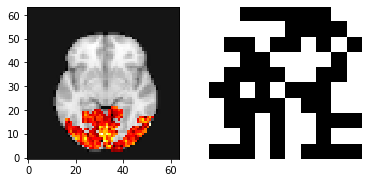

In [21]:
#Plot an example fMRI
plt_fmri_stim(recovered_data, stimuli[11], pathfile=None)

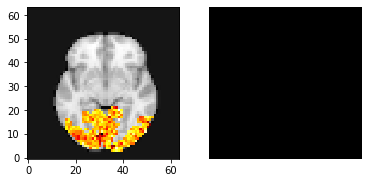

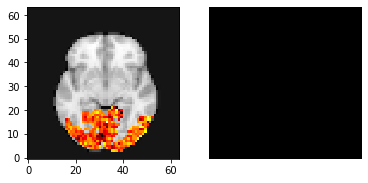

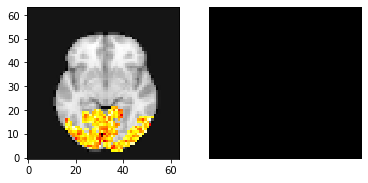

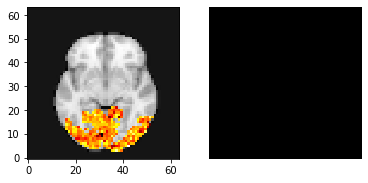

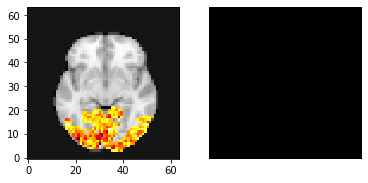

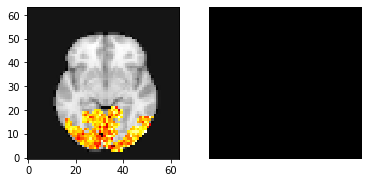

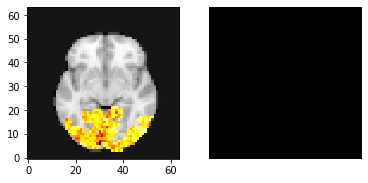

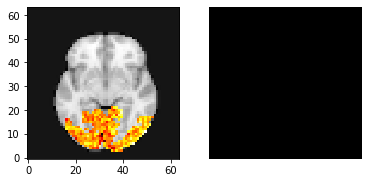

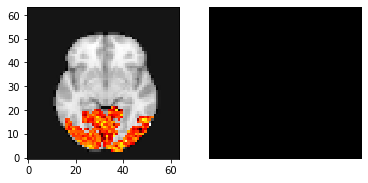

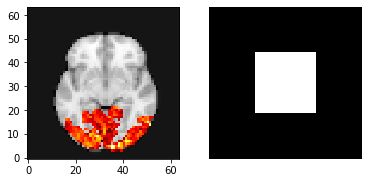

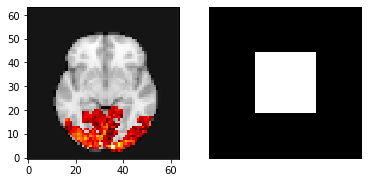

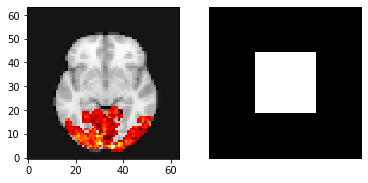

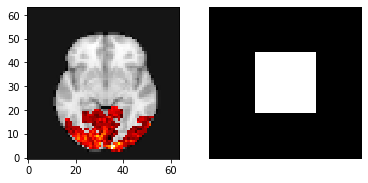

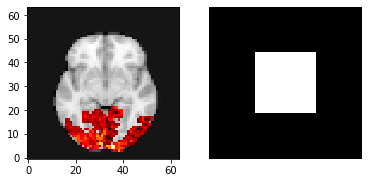

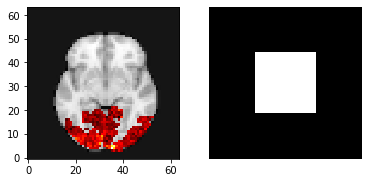

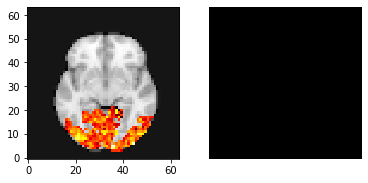

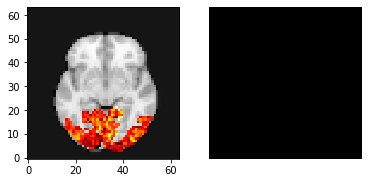

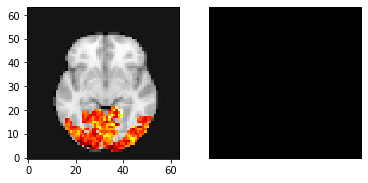

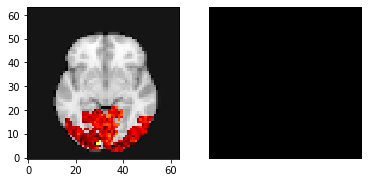

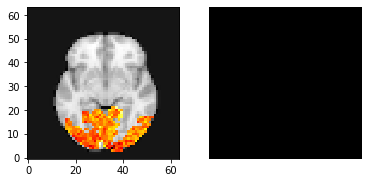

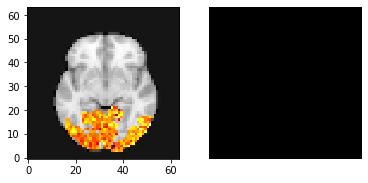

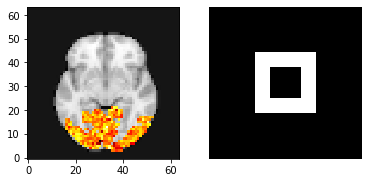

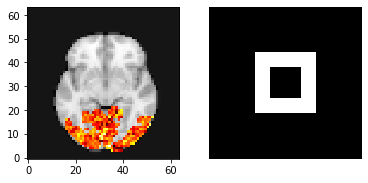

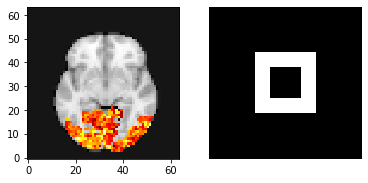

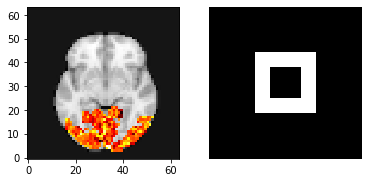

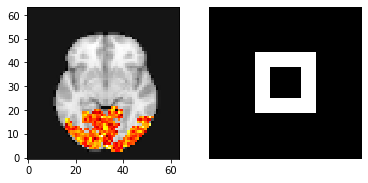

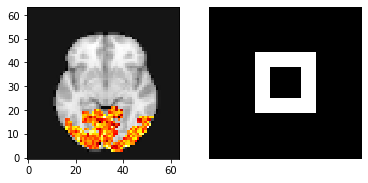

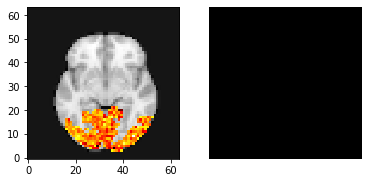

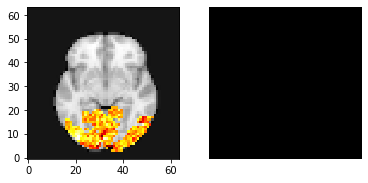

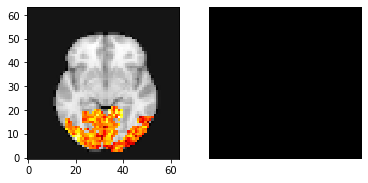

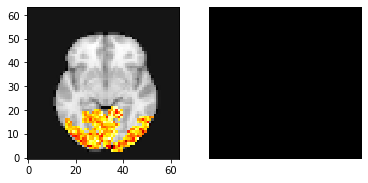

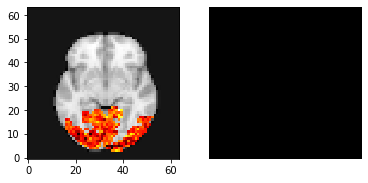

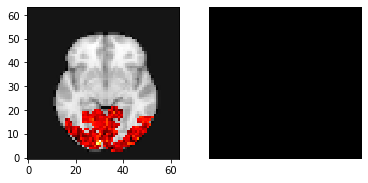

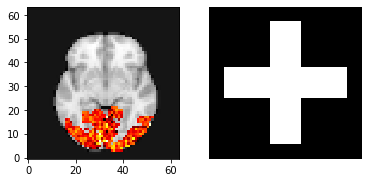

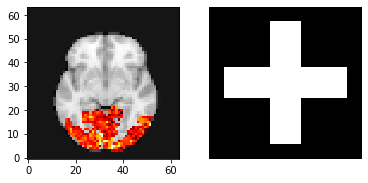

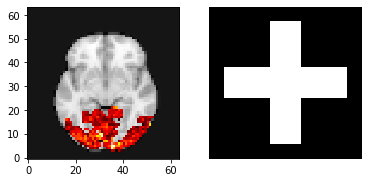

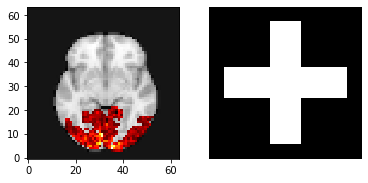

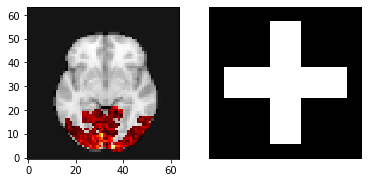

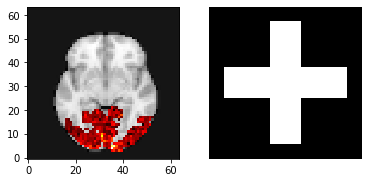

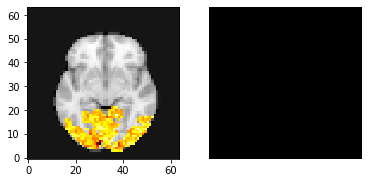

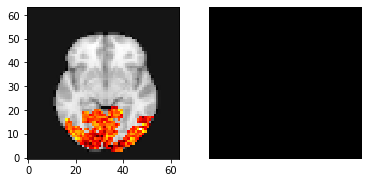

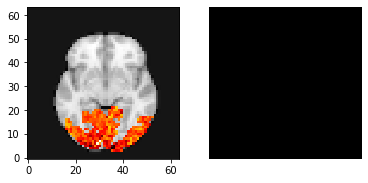

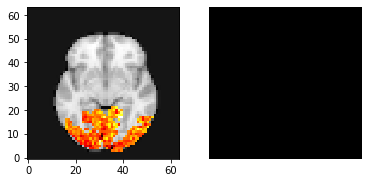

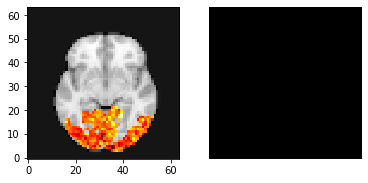

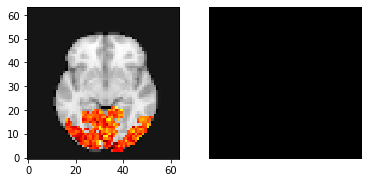

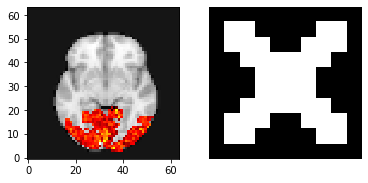

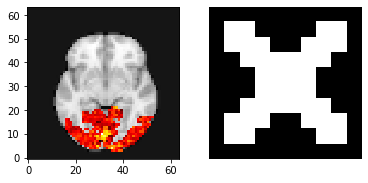

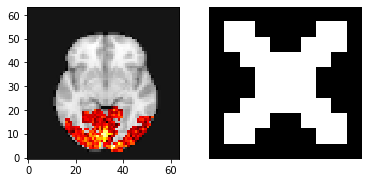

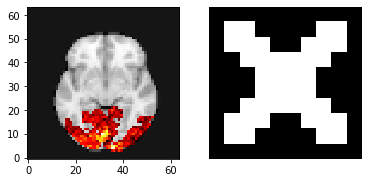

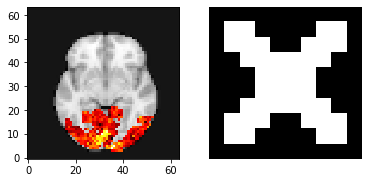

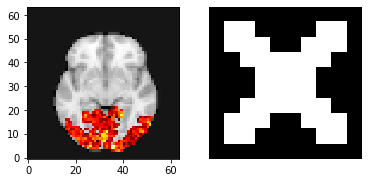

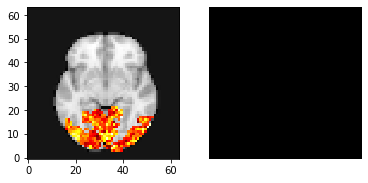

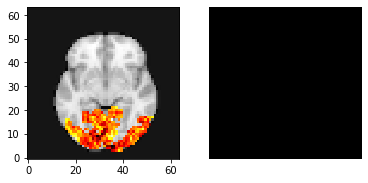

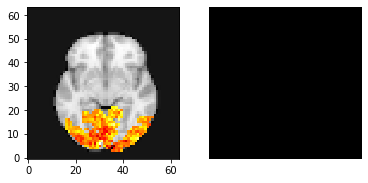

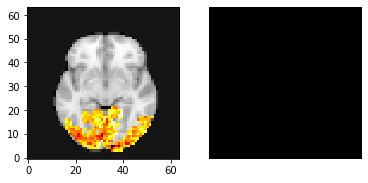

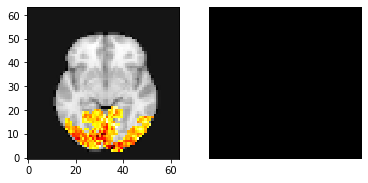

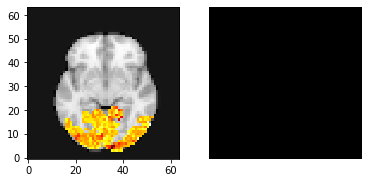

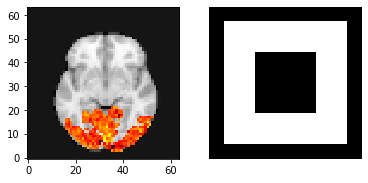

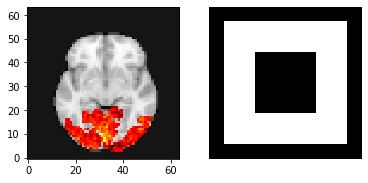

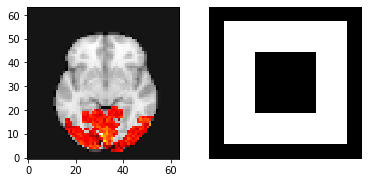

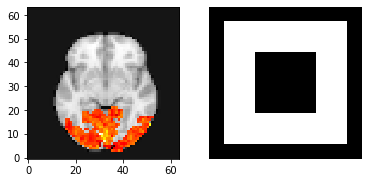

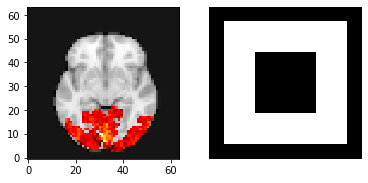

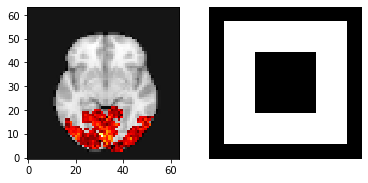

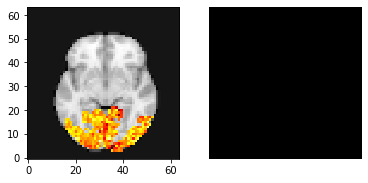

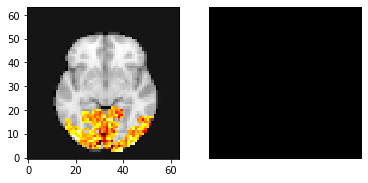

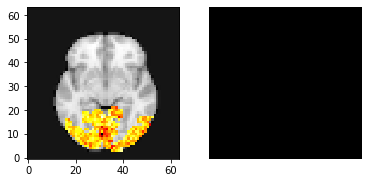

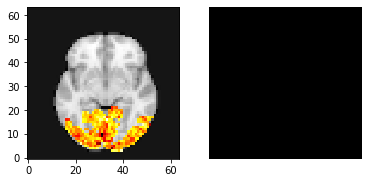

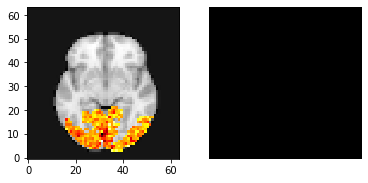

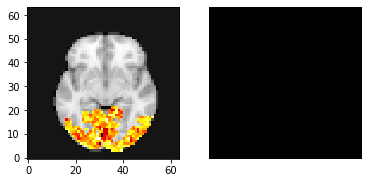

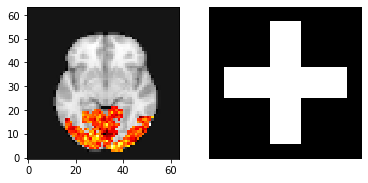

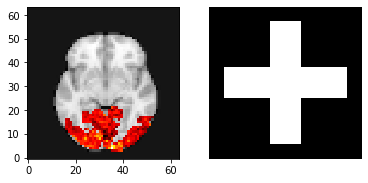

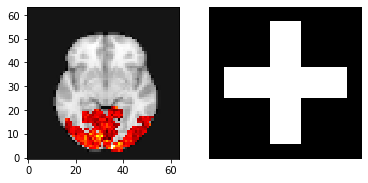

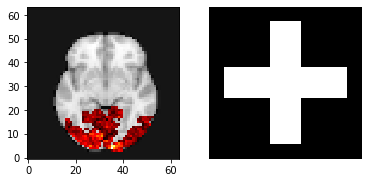

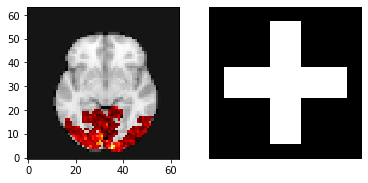

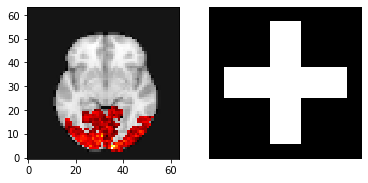

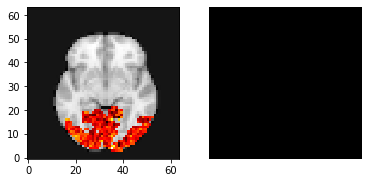

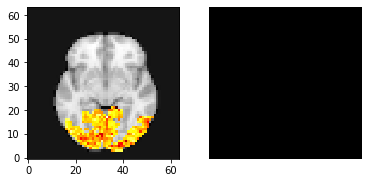

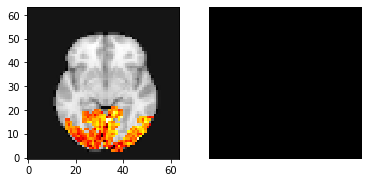

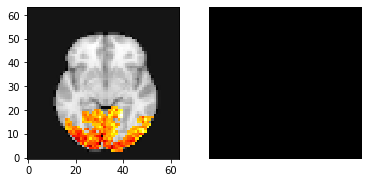

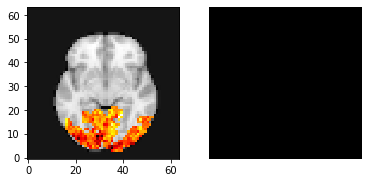

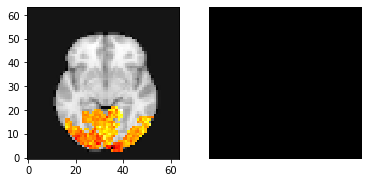

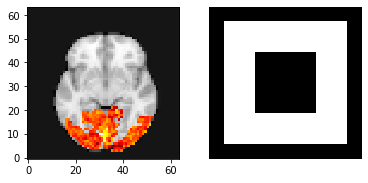

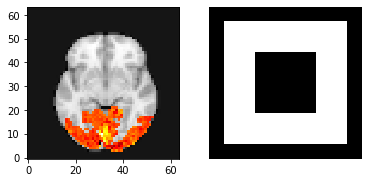

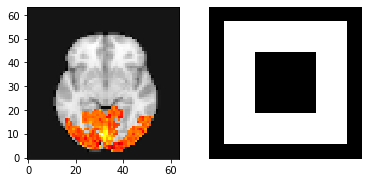

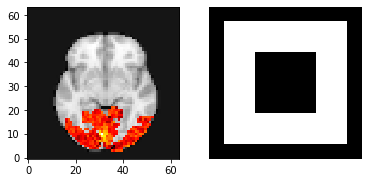

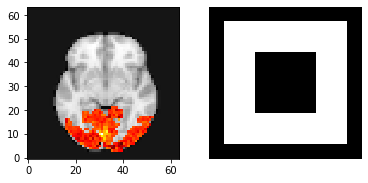

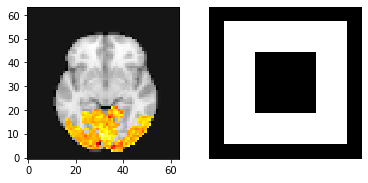

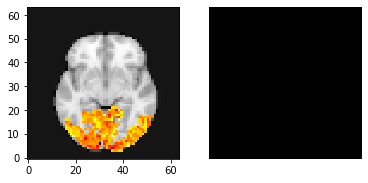

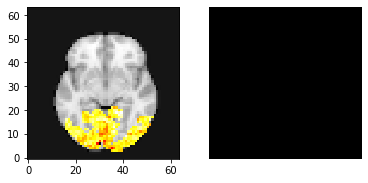

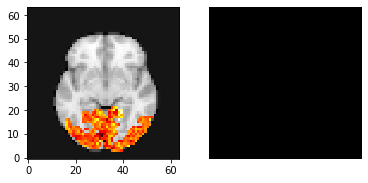

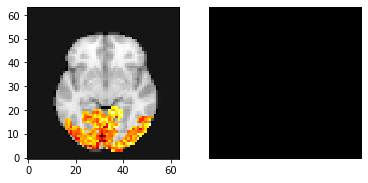

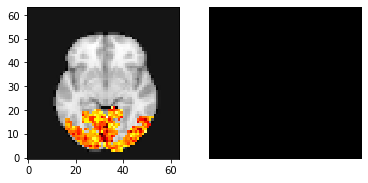

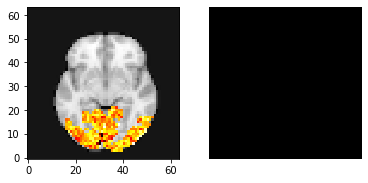

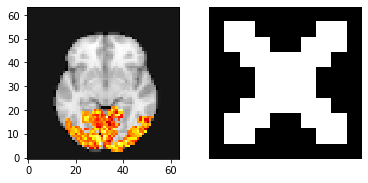

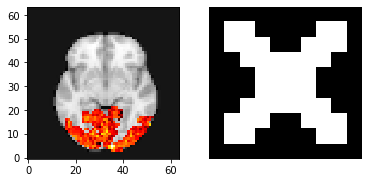

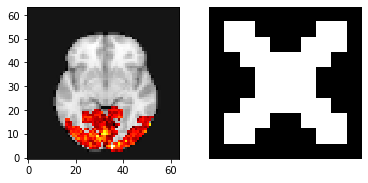

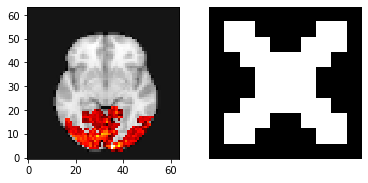

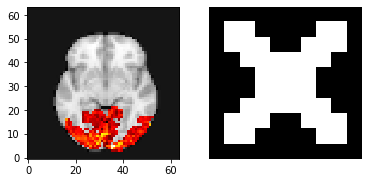

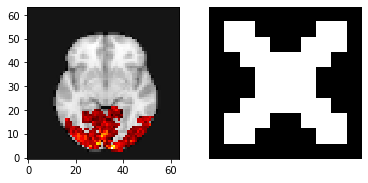

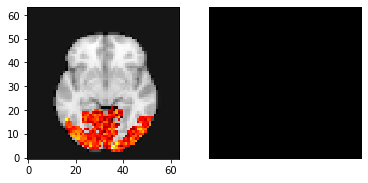

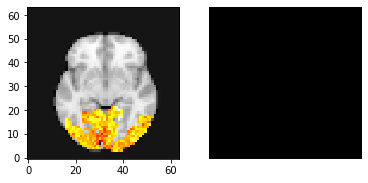

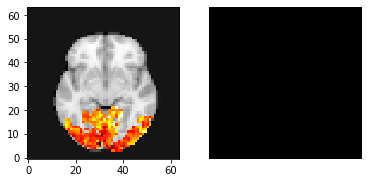

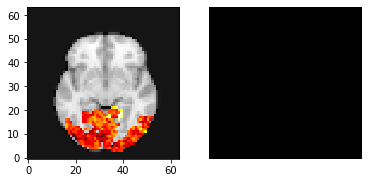

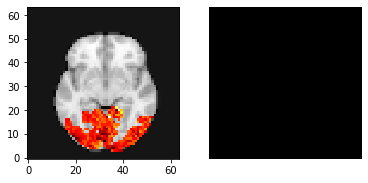

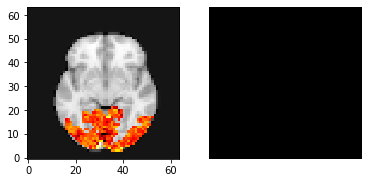

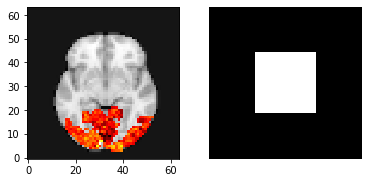

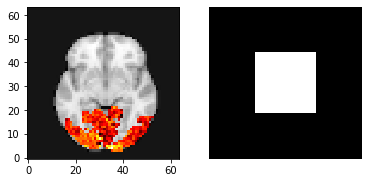

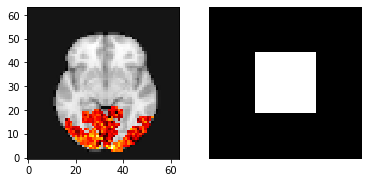

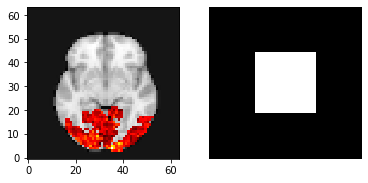

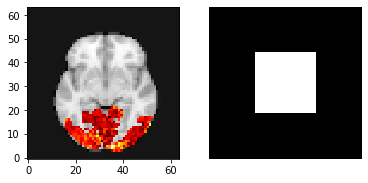

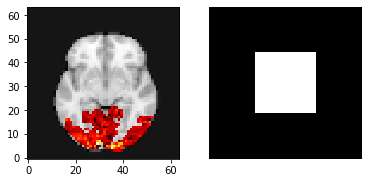

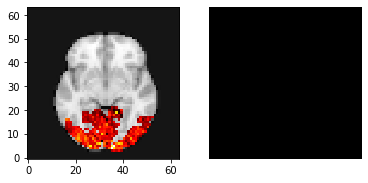

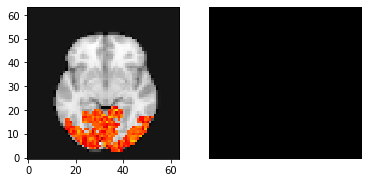

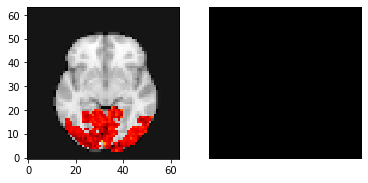

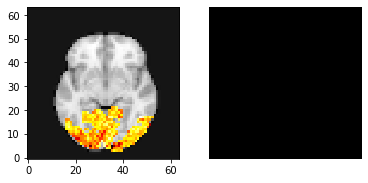

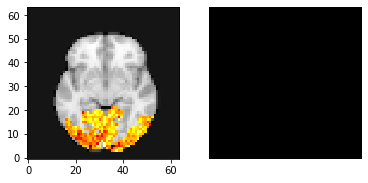

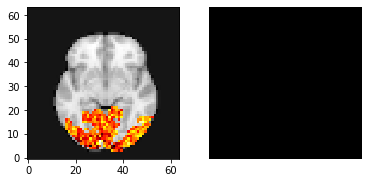

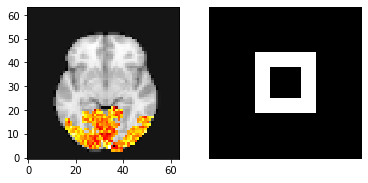

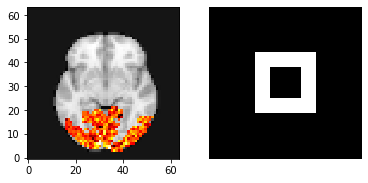

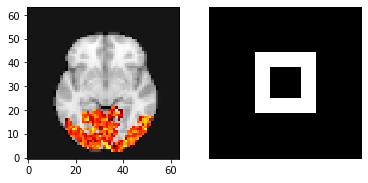

In [36]:
#Let's make a pretty video
#Create the images
i=0
while i < 120:
    i+=1
    recovered_data = masker.inverse_transform(fmri_figures_data[i])
    plt_fmri_stim(recovered_data, stimuli_figures[i], pathfile='/Users/pierrehouzelstein/Documents/GitHub/Machine-Learning-PCS2/code/images/data_'+str(i)+'.png')    

In [37]:
#Sort them
import re

def natural_sort_key(s, _nsre=re.compile('([0-9]+)')):
    return [
        int(text)
        if text.isdigit() else text.lower()
        for text in _nsre.split(s)]

image_folder = '/Users/pierrehouzelstein/Documents/GitHub/Machine-Learning-PCS2/code/images'
sorted_images = sorted(os.listdir(image_folder), key=natural_sort_key)

In [38]:
#create the video
import cv2
import os

video_name = 'video.avi'

images = [img for img in sorted_images if img.endswith(".png")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 4, (width,height))

for image in sorted_images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()

In [4]:
#erase black figs: useless for our use of the data
print(np.shape(stimuli))
print(np.shape(fmri_data))
print(np.shape(stimuli_figures))
print(np.shape(fmri_figures_data))
        
stimuli2 = np.array([element for element in stimuli if np.sum(element) != -100])
fmri_data2 = np.array([fmri_data[i] for i in range(len(fmri_data)) if np.sum(stimuli[i]) != -100])

    
print(np.shape(stimuli2))
print(np.shape(fmri_data2))

stimuli_figures2 = np.array([element for element in stimuli_figures if np.sum(element) != -100])
fmri_figures_data2 = np.array([fmri_figures_data[i] for i in range(len(fmri_figures_data)) if np.sum(stimuli_figures[i]) != -100])

    
print(np.shape(stimuli_figures2))
print(np.shape(fmri_figures_data2))

(2860, 100)
(2860, 5438)
(1536, 100)
(1536, 5438)
(1320, 100)
(1320, 5438)
(720, 100)
(720, 5438)


### Preprocessing for multi scale encoding

In [ ]:
# Preprocessing of stimuli data for multi scale encoding

# Fist we create the list pixel_indices of 4-uplets of incidices of pixels we want to average together for the 2*2
k = [2*i for i in range(5)] #list used to generate pixel_indices
pixel_indices = [[10*a+b, 10*a+(b+1), 10*(a+1)+b, 10*(a+1)+(b+1)] for a in k for b in k]

def preproc_one_stimuli(idx_pxl_toavg, stimuli, reshape = False, reshape_form = (5,5)) :
    """
    Permits to preproc 1 stimuli figure by averaging some pixels together for the 
    multiscale encoding.
    - idx_pxl_toavg : liste de multiplets d'indices de pixels que l'on souhaite moyenner
                      ensemble. Par ex, pour le 2*2 on a :
                      [[0,1,10,11], [2,3,12,13], ... ,[88,89,98,99]].
    - stimuli: the image
    - reshape : if you want your image to be reshaped in such a way that you can plot it
    - reshape_form : (5,5) for a 5 by 5 image, etc...
    """
    if reshape == False :
        return np.array([np.average([stimuli[i] for i in idx]) for idx in idx_pxl_toavg])
    
    else :
        return np.array(np.reshape([np.average([stimuli[i] for i in idx]) for idx in idx_pxl_toavg],(5,5)))
    

def preproc_multiple_stimuli(idx_pxl_toavg, stimuli_list, reshape = False, reshape_form = (5,5)) :
    """
    Same as above but to preproc a whole list of stimulis
    Sorry this looks horrible
    """
    if reshape == False :
        return np.array([[np.average([stimuli[i] for i in idx]) for idx in idx_pxl_toavg] for stimuli in stimuli_list])
    
    else :
        reshape_form_multi = (len(stimuli_list),reshape_form[0],reshape_form[1])
        return np.array(np.reshape([np.average([stimuli[i] for i in idx]) for idx in idx_pxl_toavg for stimuli in stimuli_list],reshape_form_multi))

In [ ]:
# Check that stimuli processing works

imag = stimuli_figures2[30]
old = np.reshape(imag,(10,10))
    
new = preproc_one_stimuli(pixel_indices, imag, reshape = True)

fig = plt.figure()
sp1 = plt.subplot(121)
sp2 = plt.subplot(122)

# to show the grid 
ax = plt.gca()

for ax in (sp1, sp2) :

    # Major ticks
    ax.set_xticks(np.arange(0, 10, 1))
    ax.set_yticks(np.arange(0, 10, 1))

    # Minor ticks
    ax.set_xticks(np.arange(-.5, 10, 1), minor=True)
    ax.set_yticks(np.arange(-.5, 10, 1), minor=True)


sp1.imshow(old, cmap = plt.cm.gray, interpolation = 'nearest')
sp2.imshow(new, cmap = plt.cm.gray, interpolation = 'nearest')

sp2.grid(which='minor', color='r', linestyle='-', linewidth=2)
sp1.grid(which='minor', color='r', linestyle='-', linewidth=2)

## First step: Decoding


Let's infer the binary visual stimulus presented to the subject from the recorded fMRI data.

Simple classification: X = fMRI data, y = binary stimuli

As done in Abraham et al., we first use a l1 logistic regression

Issue: the article is from 2014, so some of the code is deprecated: need to correct it

In [ ]:
"""from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif

pipeline_LR = Pipeline(steps=[('selection', SelectKBest(f_classif, k=500)),('clf', LR(penalty='l1', C=0.05))])

scores_lr = []
# y_train = n_samples x n_voxels
# To iterate on voxels, we transpose it. 
for pixel in tqdm(y_train.T):
    score = cross_val_score(pipeline_LR, X_train, pixel, cv=5)
    scores_lr.append(score)"""

In [24]:
from sklearn.model_selection import train_test_split

train_to_test_ratio = 0.8
X_train, X_test, Y_train, Y_test =train_test_split(fmri_data2, stimuli2, 
                                        train_size=train_to_test_ratio, 
                                        test_size=1.0-train_to_test_ratio)

In [7]:
from sklearn import linear_model
from sklearn.preprocessing import scale

C_list = [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]

logreg_table = []
train_accuracy, test_accuracy = np.zeros(100), np.zeros(100)

#Train pixel by pixel: fit a logreg for each pixel
for i,pixel in tqdm(enumerate(np.transpose(Y_train))):
    
    # define logistic regressor
    logreg = linear_model.LogisticRegression(penalty='l2', C=0.05, max_iter = 10000)
    
    # fit training data
    logreg.fit(X_train, pixel)
    
    logreg_table.append(logreg)
    
    # check accuracy
    train_accuracy[i]=logreg.score(X_train,pixel)
    test_accuracy[i]=logreg.score(X_test, np.transpose(Y_test)[i])
    
    print('accuracy: train, test')
    print('liblin: %0.4f, %0.4f' %(train_accuracy[i],test_accuracy[i]) )

1it [00:01,  1.36s/it]

accuracy: train, test
liblin: 1.0000, 0.5795


2it [00:03,  2.03s/it]

accuracy: train, test
liblin: 1.0000, 0.6553


3it [00:06,  2.26s/it]

accuracy: train, test
liblin: 1.0000, 0.6553


4it [00:10,  2.83s/it]

accuracy: train, test
liblin: 1.0000, 0.5947


5it [00:11,  2.26s/it]

accuracy: train, test
liblin: 1.0000, 0.6023


6it [00:12,  2.01s/it]

accuracy: train, test
liblin: 1.0000, 0.5795


7it [00:15,  2.16s/it]

accuracy: train, test
liblin: 1.0000, 0.5909


8it [00:18,  2.42s/it]

accuracy: train, test
liblin: 1.0000, 0.6023


9it [00:21,  2.52s/it]

accuracy: train, test
liblin: 1.0000, 0.6250


10it [00:23,  2.58s/it]

accuracy: train, test
liblin: 1.0000, 0.5985


11it [00:26,  2.52s/it]

accuracy: train, test
liblin: 1.0000, 0.5985


12it [00:28,  2.57s/it]

accuracy: train, test
liblin: 1.0000, 0.6364


13it [00:31,  2.66s/it]

accuracy: train, test
liblin: 1.0000, 0.6515


14it [00:34,  2.77s/it]

accuracy: train, test
liblin: 1.0000, 0.6288


15it [00:36,  2.32s/it]

accuracy: train, test
liblin: 1.0000, 0.6098


16it [00:38,  2.36s/it]

accuracy: train, test
liblin: 1.0000, 0.6402


17it [00:42,  2.78s/it]

accuracy: train, test
liblin: 1.0000, 0.6326


18it [00:44,  2.67s/it]

accuracy: train, test
liblin: 1.0000, 0.6439


19it [00:47,  2.66s/it]

accuracy: train, test
liblin: 1.0000, 0.6326


20it [00:49,  2.65s/it]

accuracy: train, test
liblin: 1.0000, 0.6174


21it [00:51,  2.23s/it]

accuracy: train, test
liblin: 1.0000, 0.6439


22it [00:52,  1.92s/it]

accuracy: train, test
liblin: 1.0000, 0.7083


23it [00:55,  2.17s/it]

accuracy: train, test
liblin: 1.0000, 0.7008


24it [00:57,  2.27s/it]

accuracy: train, test
liblin: 1.0000, 0.7083


25it [01:00,  2.37s/it]

accuracy: train, test
liblin: 1.0000, 0.7348


26it [01:02,  2.46s/it]

accuracy: train, test
liblin: 1.0000, 0.6477


27it [01:05,  2.39s/it]

accuracy: train, test
liblin: 1.0000, 0.7083


28it [01:07,  2.41s/it]

accuracy: train, test
liblin: 1.0000, 0.6742


29it [01:10,  2.49s/it]

accuracy: train, test
liblin: 1.0000, 0.6970


30it [01:12,  2.50s/it]

accuracy: train, test
liblin: 1.0000, 0.6591


31it [01:14,  2.16s/it]

accuracy: train, test
liblin: 1.0000, 0.5795


32it [01:16,  2.26s/it]

accuracy: train, test
liblin: 1.0000, 0.6780


33it [01:19,  2.36s/it]

accuracy: train, test
liblin: 1.0000, 0.7803


34it [01:21,  2.36s/it]

accuracy: train, test
liblin: 1.0000, 0.8106


35it [01:24,  2.45s/it]

accuracy: train, test
liblin: 1.0000, 0.8371


36it [01:26,  2.35s/it]

accuracy: train, test
liblin: 1.0000, 0.8598


37it [01:28,  2.34s/it]

accuracy: train, test
liblin: 1.0000, 0.7917


38it [01:29,  2.02s/it]

accuracy: train, test
liblin: 1.0000, 0.6932


39it [01:32,  2.17s/it]

accuracy: train, test
liblin: 1.0000, 0.6629


40it [01:34,  2.28s/it]

accuracy: train, test
liblin: 1.0000, 0.6364


41it [01:37,  2.38s/it]

accuracy: train, test
liblin: 1.0000, 0.6629


42it [01:40,  2.43s/it]

accuracy: train, test
liblin: 1.0000, 0.6402


43it [01:42,  2.37s/it]

accuracy: train, test
liblin: 1.0000, 0.8598


44it [01:44,  2.22s/it]

accuracy: train, test
liblin: 1.0000, 0.9242


45it [01:45,  1.90s/it]

accuracy: train, test
liblin: 1.0000, 0.9848


46it [01:46,  1.52s/it]

accuracy: train, test
liblin: 1.0000, 0.9848


47it [01:48,  1.75s/it]

accuracy: train, test
liblin: 1.0000, 0.9394


48it [01:50,  1.89s/it]

accuracy: train, test
liblin: 1.0000, 0.8674


49it [01:53,  2.08s/it]

accuracy: train, test
liblin: 1.0000, 0.7197


50it [01:55,  2.20s/it]

accuracy: train, test
liblin: 1.0000, 0.7159


51it [01:58,  2.29s/it]

accuracy: train, test
liblin: 1.0000, 0.6856


52it [02:00,  2.33s/it]

accuracy: train, test
liblin: 1.0000, 0.7008


53it [02:02,  2.30s/it]

accuracy: train, test
liblin: 1.0000, 0.8447


54it [02:04,  2.17s/it]

accuracy: train, test
liblin: 1.0000, 0.9205


55it [02:05,  1.82s/it]

accuracy: train, test
liblin: 1.0000, 0.9962


56it [02:06,  1.58s/it]

accuracy: train, test
liblin: 1.0000, 0.9848


57it [02:08,  1.75s/it]

accuracy: train, test
liblin: 1.0000, 0.9697


58it [02:10,  1.79s/it]

accuracy: train, test
liblin: 1.0000, 0.9015


59it [02:13,  1.99s/it]

accuracy: train, test
liblin: 1.0000, 0.7424


60it [02:15,  2.02s/it]

accuracy: train, test
liblin: 1.0000, 0.7045


61it [02:18,  2.39s/it]

accuracy: train, test
liblin: 1.0000, 0.7235


62it [02:21,  2.45s/it]

accuracy: train, test
liblin: 1.0000, 0.6894


63it [02:23,  2.44s/it]

accuracy: train, test
liblin: 1.0000, 0.7500


64it [02:25,  2.37s/it]

accuracy: train, test
liblin: 1.0000, 0.8068


65it [02:27,  2.20s/it]

accuracy: train, test
liblin: 1.0000, 0.9015


66it [02:29,  2.13s/it]

accuracy: train, test
liblin: 1.0000, 0.8977


67it [02:31,  2.10s/it]

accuracy: train, test
liblin: 1.0000, 0.8220


68it [02:34,  2.24s/it]

accuracy: train, test
liblin: 1.0000, 0.7652


69it [02:36,  2.37s/it]

accuracy: train, test
liblin: 1.0000, 0.6553


70it [02:38,  2.06s/it]

accuracy: train, test
liblin: 1.0000, 0.6818


71it [02:40,  2.24s/it]

accuracy: train, test
liblin: 1.0000, 0.6098


72it [02:43,  2.30s/it]

accuracy: train, test
liblin: 1.0000, 0.6174


73it [02:45,  2.35s/it]

accuracy: train, test
liblin: 1.0000, 0.6742


74it [02:48,  2.40s/it]

accuracy: train, test
liblin: 1.0000, 0.6136


75it [02:49,  2.04s/it]

accuracy: train, test
liblin: 1.0000, 0.7576


76it [02:51,  2.14s/it]

accuracy: train, test
liblin: 1.0000, 0.6515


77it [02:55,  2.53s/it]

accuracy: train, test
liblin: 1.0000, 0.6023


78it [02:56,  2.16s/it]

accuracy: train, test
liblin: 1.0000, 0.6629


79it [03:00,  2.66s/it]

accuracy: train, test
liblin: 1.0000, 0.6023


80it [03:01,  2.29s/it]

accuracy: train, test
liblin: 1.0000, 0.6439


81it [03:05,  2.67s/it]

accuracy: train, test
liblin: 1.0000, 0.6553


82it [03:07,  2.64s/it]

accuracy: train, test
liblin: 1.0000, 0.6061


83it [03:09,  2.28s/it]

accuracy: train, test
liblin: 1.0000, 0.6364


84it [03:11,  2.42s/it]

accuracy: train, test
liblin: 1.0000, 0.6061


85it [03:14,  2.51s/it]

accuracy: train, test
liblin: 1.0000, 0.6174


86it [03:17,  2.69s/it]

accuracy: train, test
liblin: 1.0000, 0.6629


87it [03:20,  2.65s/it]

accuracy: train, test
liblin: 1.0000, 0.6515


88it [03:23,  2.66s/it]

accuracy: train, test
liblin: 1.0000, 0.5795


89it [03:25,  2.65s/it]

accuracy: train, test
liblin: 1.0000, 0.6023


90it [03:28,  2.65s/it]

accuracy: train, test
liblin: 1.0000, 0.6439


91it [03:29,  2.26s/it]

accuracy: train, test
liblin: 1.0000, 0.6212


92it [03:31,  2.03s/it]

accuracy: train, test
liblin: 1.0000, 0.5455


93it [03:33,  2.23s/it]

accuracy: train, test
liblin: 1.0000, 0.6439


94it [03:36,  2.30s/it]

accuracy: train, test
liblin: 1.0000, 0.6136


95it [03:38,  2.37s/it]

accuracy: train, test
liblin: 1.0000, 0.6174


96it [03:41,  2.46s/it]

accuracy: train, test
liblin: 1.0000, 0.5871


97it [03:44,  2.55s/it]

accuracy: train, test
liblin: 1.0000, 0.5038


98it [03:46,  2.54s/it]

accuracy: train, test
liblin: 1.0000, 0.6250


99it [03:48,  2.19s/it]

accuracy: train, test
liblin: 1.0000, 0.6098


100it [03:51,  2.31s/it]

accuracy: train, test
liblin: 1.0000, 0.5682


In [ ]:
print("The accuracy on our test set is " + np.mean(test_accuracy))

In [5]:
image = np.zeros(100)


n=50
xtest = fmri_figures_data2[n].reshape(1,-1)
ytest = np.reshape(stimuli_figures2[n],(10,10))

for i,pixel in enumerate(image) :
    #try: 
    y = logreg_table[i].predict(xtest)
    
    image[i] = y
    
image = np.reshape(image,(10,10))

from sklearn.preprocessing import Binarizer

image = Binarizer(threshold=0.5).fit_transform(image)

NameError: name 'logreg_table' is not defined

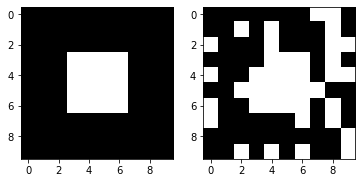

In [9]:
import matplotlib.pyplot as plt

fig = plt.figure()
sp1 = plt.subplot(121)
sp2 = plt.subplot(122)
sp1.imshow(ytest, cmap = plt.cm.gray, interpolation = 'nearest')
sp2.imshow(image, cmap = plt.cm.gray, interpolation = 'nearest')

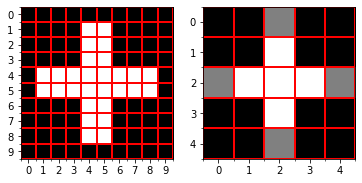

In [156]:
tot = 0

for i,elmnt in enumerate(stimuli) :
    print(np.sum(elmnt))

-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
46.0
46.0
46.0
-100.0
-100.0
-100.0
59.0
59.0
59.0
-100.0
-100.0
-100.0
50.0
50.0
50.0
-100.0
-100.0
-100.0
53.0
53.0
53.0
-100.0
-100.0
-100.0
40.0
40.0
40.0
-100.0
-100.0
-100.0
49.0
49.0
49.0
-100.0
-100.0
-100.0
59.0
59.0
59.0
-100.0
-100.0
-100.0
54.0
54.0
54.0
-100.0
-100.0
-100.0
50.0
50.0
50.0
-100.0
-100.0
-100.0
55.0
55.0
55.0
-100.0
-100.0
-100.0
50.0
50.0
50.0
-100.0
-100.0
-100.0
51.0
51.0
51.0
-100.0
-100.0
-100.0
57.0
57.0
57.0
-100.0
-100.0
-100.0
55.0
55.0
55.0
-100.0
-100.0
-100.0
43.0
43.0
43.0
-100.0
-100.0
-100.0
51.0
51.0
51.0
-100.0
-100.0
-100.0
51.0
51.0
51.0
-100.0
-100.0
-100.0
45.0
45.0
45.0
-100.0
-100.0
-100.0
61.0
61.0
61.0
-100.0
-100.0
-100.0
54.0
54.0
54.0
-100.0
-100.0
-100.0
50.0
50.0
50.0
-100.0
-100.0
-100.0
54.0
54.0
54.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
53.0
53.0
53.0
-100.0
-100.0
-100.0
57.0
57.0
57.0
-100.0
-10

## Second step: Encoding

In [1]:
from sklearn.linear_model import Ridge 
from sklearn.model_selection import KFold

cv = KFold(n_splits=10)

# Fit ridge model, calculate predictions on left out data
# and evaluate r^2 score for each voxel
scores = []
for train, test in tqdm(cv.split(y_train)):
    pred = (Ridge(alpha=100.).fit(y_train[train], X_train[train]).predict(y_train[test]))
    X_true = X_train[test]
    scores.append(1. - ((X_true - pred)** 2).sum(axis=0) /((X_true - X_true.mean(axis=0))** 2).sum(axis=0))
mean_scores = np.mean(scores, axis=0)


NameError: name 'tqdm' is not defined

In [19]:
from sklearn.linear_model import LassoLarsCV
# choose number of voxels to treat, set to None for all voxels
n_voxels = 50
# choose best voxels
indices = mean_scores.argsort()[::-1][:n_voxels]
lasso = LassoLarsCV(max_iter=10)
receptive_fields = [] 
for index in indices:
    lasso.fit(y_train, X_train[:, index])
    receptive_fields.append(lasso.coef_.
        reshape(10, 10))